# Graded Exercise 2 - Sampling with Boltzmann Machines and MCMC

## General instruction
Each question is provided in a _Markdown_ cell and should be answered in the cell(s) below. You may add new cells if needed. All figures must be generated and shown directly in this notebook. If a question demands that you write an answer, use a _Markdown_ cell, which can include latex between \\$ symbols. As an example,
\\$\vec{F}=m\vec{a}\\$
gives $\vec{F}=m\vec{a}$.

Your code should run properly if you do the following: 1) restart the kernel 2) execute all cells in order from top to bottom. Running all cells should take a reasonable time on a standard computer or on Noto (<30 min.). Note that this exercise will require longer execution time than the first graded homework.

Avoid using `for` loops whenever possible. Instead, use vectorized operations or numpy functions.

All external sources you consult must be explicitly cited, except for the official NumPy, Scipy and Matplotlib documentation, the lecture notes, and previous exercises. You are encouraged to use external sources, since every function needed in this exercise has not necessarily been seen in the previous exercises. Please also cite every person you discussed this exercise with.

Overly long or unnecessarily complicated answers will be penalized.

## Context

In 2024, Geoffrey Hinton, one of the pioneers of deep learning, was awarded the Nobel Prize in Physics for his foundational contributions to energy-based models. His work demonstrated that ideas from physics, such as energy landscapes, entropy, and thermal fluctuations, can be used to build computational models capable of learning complex patterns from data. Central to this achievement is the Boltzmann machine, a model defined primarily by an energy function over binary variables, an idea directly inspired by the Ising model in physics.

In this exercise, you will train a Boltzmann machine or variants thereof to approximately sample from a high-dimensional distribution.

In part 1-4, we investigate the performance of various energy-based models on a synthetic dataset. In part 5, we study the performance of a specific energy-based model on a real dataset.

# 1. The bars and stripes dataset

__1.1__ Load the dataset *bars_and_stripes.npy* with the numpy `load` function. Print its shape. 

In [1]:
# Your code here

In [2]:
# Solution
import numpy as np
data_BAS=np.load('bars_and_stripes.npy')

__1.2__ The *bars_and_stripes.npy* dataset consists of black and white images. Using `imshow` from the matplotlib library, draw the first 10 images of the dataset. Comment briefly on the content of this dataset.

In [3]:
# Your code here

Your answer here:

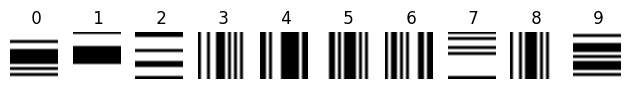

In [4]:
# Solution
import matplotlib.pyplot as plt
num_plots=10
fig, axes = plt.subplots(1, num_plots)

for i in range(num_plots):
    ax = axes[i]
    ax.imshow(data_BAS[i], cmap='grey')
    ax.set_title(f" {i}")
    ax.axis('off')

plt.tight_layout()
plt.show()

Solution:

The dataset consists of two classes. One has only horizontal lines (strips), the other has only vertical lines (bars). The position of the bars seems to be uniformly distributed over the length/w


From now on, we treat each image as a flattened vector 
$$\mathbf s_\mu=(s_1^\mu, s_2^\mu, ..., s_{d}^\mu),\quad s_i\in\{0, 1\}.$$
$\mu=1, ..., n$ is the sample index, and denote the whole dataset as $S$.

**1.3** Reshape the dataset to a size $n\times d$, where $n$ indicates the number of samples and $d$ the number of pixels in each image. 

In [5]:
# Your code here

In [6]:
n, sqrt_d, _=data_BAS.shape
d=sqrt_d**2
data_BAS=data_BAS.reshape(n, sqrt_d**2)

We will now study various parameterized probability distribution of the form
$$
P_\theta(\mathbf s)=\frac{e^{-E_\theta(\mathbf s)}}{Z_\theta}.
$$
$\theta$ are the parameters of the distribution, that we will find to match the given data. $E_\theta$ is a function that depends on the parameters $\theta$ and $\mathbf s$. $Z_\theta$ is the normalization such that $P_\theta$ is a proper probability distribution. Distributions of this form are called *Boltzmann* or *Gibbs* distribution. Note that to model physical systems, the $E_\theta$ is the energy and is usually multiplied by a term proportional to the inverse temperature.

# 2. Independent field model

We first define the energy of the independent field model as
$$
E_{\mathbf h}(\mathbf s)=\sum_{i=1}^d h_i s_i, \quad \mathbf h\in\mathbb{R}^d
$$
where $h_i$ are scalar parameter associated to pixel $i$. We consider the Boltzmann distribution associated to this energy
$$
P_{\mathbf{h}} (\mathbf s)=\frac{1}{Z_{\mathbf h}}e^{- E_{\mathbf h}(\mathbf s)}.
$$

**2.1** Show that in this model each pixel is statistically independent of the others.


Your answer here:

Solution :

We have that
$$
P_{\mathbf{h}} (\mathbf s)=\frac{1}{Z_{\mathbf h}}e^{- E_{\mathbf h}(\mathbf s)}=\frac{1}{Z_{\mathbf h}}e^{-\sum_{i=1}^d h_i s_i}=\frac{1}{Z_{\mathbf h}}\prod_{i=1}^d e^{-h_i s_i}.
$$
Additionally, the partition function factorizes to
$$
Z_{\mathbf h} = \sum_{\mathbf s \in \{0,1\}^d} e^{-\sum_{i=1}^d h_i s_i}
=
\prod_{i=1}^d \sum_{s_i\in \{0, 1\}}e^{-h_i s_i}=\prod_{i=1}^d(1+e^{-h_i})
$$
Thus,
$$
P_{\mathbf{h}} (\mathbf s)=\prod_{i=1}^d \frac{e^{-h_i s_i}}{1+e^{-h_i}}=\prod_{i=1}^d P_{h_i}(s_i)\quad \textrm{with}\quad P_{h_i}(s_i)=\frac{e^{-h_i s_i}}{1+e^{-h_i}}.
$$
As the joint probability distribution of the pixel color decomposes into a product over the marginal probability of each pixel, they are independent.

**2.2** The empirical and model averages are
$$
<s_i>_{emp}=\frac{1}{n}\sum_{\mu=1}^n s_i^\mu,
$$
$$
<s_i>_{model}=\sum_{\mathbf s\in\{0,1\}^d} s_i P_{\mathbf h}(\mathbf s).
$$
Note here that $s_i^\mu$ is component $i$ of sample $\mu$, while $s_i$ is a dummy variable which we sum over.
We study this problem with maximum likelihood estimation.
We want to find $\hat{\mathbf h}$ that minimizes the negative log-likelihood $\mathcal{L}(\mathbf h)=-\sum_{\mu=1}^n \log P_{\mathbf h}(\mathbf s_\mu)$. Show that this entails finding $\hat{\mathbf h}$ such that
$$
<s_i>_{emp}=<s_i>_{model}.
$$

Note: you can reuse the expression derived in the previous question. You are not required to check that $\hat{\mathbf h}$ is a minimum, it is sufficient to impose that it is a stationary/extremal point.

Your answer here:

Solution:

The negative log-likelihood to observe the given data is
$$
\mathcal{L}(\mathbf h)=-\sum_{\mu=1}^n \log P_{\mathbf h}(\mathbf s_\mu)
=-\sum_{\mu=1}^n \log\left(\frac{e^{-\sum_{i=1}^d h_i s_i^\mu}}{Z_{\mathbf h}} \right)
=
\sum_{\mu=1}^n \sum_{i=1}^d h_i s_i^\mu + n \sum_{i=1}^d\log (1+e^{-h_i})
$$
We want to minimize this quantity by choosing the appropriate $\mathbf h$. The derivative is
$$
\frac{\partial \mathcal{L(\mathbf h)}}{h_i}=\sum_{\mu=1}^n s_i^\mu-n\frac{e^{-h_i}}{1+e^{-h_i}} = n(<s_i>_{emp}-P_{h_i}(s_i=1))
$$
Indeed, we know from the previous exercise that $P_{h_i}(s_i)=\frac{e^{-h_i s_i}}{1+e^{-h_i}}$. Additionally, as $s_i\in\{0,1\}$ we have that $P_{h_i}(s_i=1)=<s_i>_{model}$.

Thus, setting the gradient to $0$ imposes that
$$
<s_i>_{emp}=<s_i>_{model}
$$
We can additionally easily check that this is the minimum of $\mathcal{L}$ by computing the second derivative.

**2.3** Deduce that
$$
\hat h_i = \log\left(\frac{1-<s_i>_{emp}}{<s_i>_{emp}}\right).
$$

Your answer here:

Solution :

The previous condition imposes that
$$
<s_i>_{emp}=<s_i>_{model}=P_{\hat h_i}(s_i=1)=\frac{e^{-\hat h_i}}{1+e^{-\hat h_i}}=\frac{1}{1+e^{\hat h_i}} \Rightarrow e^{\hat h_i}=\frac{1}{<s_i>_{emp}}-1.
$$
Thus,
$$
\hat h_i=\log\left(\frac{1}{<s_i>_{emp}}-1\right)=\log\left( \frac{1-<s_i>_{emp}}{<s_i>_{emp}}\right).
$$

**2.4** Show that 
$$
P_{\hat h_i}(s_i)=\begin{cases}
  <s_i>_{emp} & \text{if } s_i=1, \\
  1-<s_i>_{emp}  & \text{if } s_i=0
\end{cases}
$$
where $P_{\hat h_i}(s_i)$ is the marginal probability that pixel $i$ has color $s_i$.

Your answer here:

Solution:

Inserting $\hat h_i$ into the marginal $P_{\hat h_i}(s_i)$ deduced previously, we have
$$
    P_{\hat{\mathbf{h}}}(s_i)=\frac{e^{-\log(1/<s_i>_{emp}-1)s_i}}{1+e^{-\log(1/<s_i>_{emp}-1)}}=
    \frac{e^{-\log(1/<s_i>_{emp}-1)s_i}}{1+\frac{<s_i>_{emp}}{1-<s_i>_{emp}}}=
    e^{-\log(1/<s_i>_{emp}-1)s_i}(1-<s_i>_{emp}).
$$
Thus, we sample $s_i=0$ with probability $1- <s_i>_{emp}$, while we sample $s_i=1$ with probability $<s_i>_{emp}$. I.e. this is just a Bernoulli random variable with parameter $p=<s_i>_{emp}$.


**2.5** Write a function `sample_independent` that takes as parameter the empirical mean $<s_i>_{emp}$ and *num_samples* which samples *num_samples* images $\mathbf s$.

In [7]:
# Your code here:

In [8]:
# Solution:
rng=np.random.default_rng(seed=1)
def sample_independent(emp_mean, num_samples=1000):
    return (rng.random((num_samples, len(emp_mean)))<emp_mean).astype(int)

**2.6** Draw 5 samples with $\mathbf h=\hat{\mathbf h}$ (i.e. with the probability distribution of 2.4) and plot them as images. What do you see ? Is it expected ? Comment briefly.

In [9]:
# Your code here:

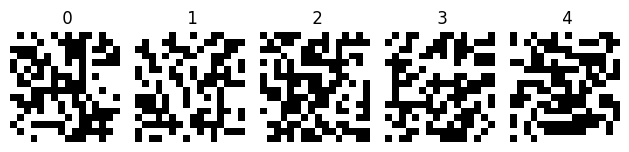

In [10]:
# Solution
emp_mean=np.mean(data_BAS, axis=0)
num_samples=5
samples=sample_independent(emp_mean, num_samples=num_samples)

fig, axes = plt.subplots(1, num_samples)
for i in range(num_samples):
    ax = axes[i]
    ax.imshow(samples[i].reshape(16,16), cmap='grey')
    ax.set_title(f" {i}")
    ax.axis('off')

plt.tight_layout()
plt.show()

Your answer here:

Solution:

Each pixel seems to be drawn at random. The structure of the dataset is not preserved at all. This is expected as the correlation necessary to have bars and strips are not present in the model.

**2.7** Print the empirical mean $<\mathbf{s}>_{emp}$ that you computed. What do you observe ? What does this indicate about the dataset ? 

In [11]:
# Your code here:

Your solution here:

In [12]:
print(emp_mean)


[0.52  0.516 0.478 0.502 0.534 0.538 0.5   0.502 0.476 0.534 0.514 0.522
 0.524 0.5   0.516 0.528 0.518 0.514 0.476 0.5   0.532 0.536 0.498 0.5
 0.474 0.532 0.512 0.52  0.522 0.498 0.514 0.526 0.526 0.522 0.484 0.508
 0.54  0.544 0.506 0.508 0.482 0.54  0.52  0.528 0.53  0.506 0.522 0.534
 0.506 0.502 0.464 0.488 0.52  0.524 0.486 0.488 0.462 0.52  0.5   0.508
 0.51  0.486 0.502 0.514 0.508 0.504 0.466 0.49  0.522 0.526 0.488 0.49
 0.464 0.522 0.502 0.51  0.512 0.488 0.504 0.516 0.536 0.532 0.494 0.518
 0.55  0.554 0.516 0.518 0.492 0.55  0.53  0.538 0.54  0.516 0.532 0.544
 0.504 0.5   0.462 0.486 0.518 0.522 0.484 0.486 0.46  0.518 0.498 0.506
 0.508 0.484 0.5   0.512 0.496 0.492 0.454 0.478 0.51  0.514 0.476 0.478
 0.452 0.51  0.49  0.498 0.5   0.476 0.492 0.504 0.508 0.504 0.466 0.49
 0.522 0.526 0.488 0.49  0.464 0.522 0.502 0.51  0.512 0.488 0.504 0.516
 0.496 0.492 0.454 0.478 0.51  0.514 0.476 0.478 0.452 0.51  0.49  0.498
 0.5   0.476 0.492 0.504 0.502 0.498 0.46  0.484 0.516 

Solution:

Each $h_i\approx 0.5$. This means that the average value of each pixel is $0.5$. Thus, there does not seem to be some bar or strip configuration that is more probable than the other.

# 3. Boltzmann Machines

The Boltzmann machine assumes the following energy function:
$$
E_{\mathbf h, J}(\mathbf s)=-\sum_i h_i s_i-\sum_{i<j} J_{ij} s_i s_j.
$$
$J\in \mathbb{R}^{d\times d}$ are symmetric couplings ($J_{ij}=J_{ji}$), and $\mathbf h$ is as before. These are the parameters that one wants to learn. Contrary to the independent field model, there is no analytical expression to obtain $\hat J$ and $\hat{\mathbf h}$, the parameters that maximize the log-likelihood of this problem. Thus, we will estimate them using gradient descent (see also lecture 12 for more details):
$$
h_i(t+1)=h_i(t)-\eta \left( <s_i>_{model} - <s_i>_{emp}\right),
$$
$$
J_{ij}(t+1)=J_{ij}(t)-\eta \left( <s_i s_j>_{model} - <s_i s_j>_{emp}\right).
$$
To obtain the quantities $<\cdot>_{model}$, we will use Monte Carlo Markov Chains (MCMC). However, running a whole MCMC for each iteration of the gradient descent is computationally demanding. Instead of initializing the chain at a random $\mathbf s$, we start $n$ chains on each data point and run only a few MCMC steps. This is called *contrastive divergence*.

We will update these short MCMC using __Gibbs__ sampling, where each spin is resampled from its conditional distribution given all the others. The transition from a state $a$ to $b$ is in this case given by
$$
P(b\rightarrow a)=\frac{e^{-E(a)}}{e^{-E(a)}+e^{-E(b)}},
$$
where $a$ and $b$ differe at most at one pixel $s_i$. In the other cases the transition probability is $0$.
Note that other sampling schemes are also possible, such as the Metropolis algorithm.

**3.1** Show that the Gibbs sampling Markov chain satisfies detailed balance for the stationary distribution given by the Boltzmann measure with energy $E_{\mathbf h, J}(\mathbf s)$

Your answer here:

Solution:

We want to show that 
$$
P(a\rightarrow b)\pi(a)=P(b\rightarrow a)\pi(b)
$$
where $\pi$ is the stationary distribution of the chain, which the Boltzmann measure in our case. Then, if $a$ and $b$ differ at most in one pixel $s_i$, we have
$$
P(a\rightarrow b)\pi(a)=\frac{e^{-E(b)}}{e^{-E(b)}+e^{-E(a)}} \frac{e^{-E(a)}}{Z},
$$
$$
P(b\rightarrow a)\pi(b)=\frac{e^{-E(a)}}{e^{-E(a)}+e^{-E(b)}} \frac{e^{-E(b)}}{Z},
$$
and these two quantities are equivalent. If $a$ and $b$ differ at more that one pixel, the transition probability is $0$ and we also recover detailed balance.

**3.2** We define $\Delta E_i$ as the difference in energy between pixel $i$ being $0$ and $1$:
$$
    \Delta E_i=E_{\mathbf{h}, J}(s_i=0)-E_{\mathbf{h}, J}(s_i=1)=h_i+\sum_{j\neq i}J_{ij}s_j
$$
Using the definition of the Boltzmann measure, show that
$$
    P_{\mathbf h, J}(s_i=1 | s_{-i})=\frac{1}{1+e^{-\Delta E_i}}
$$
where $s_{-i}$ indicates all $s_j$ except for $j=i$ (i.e. we fix every pixel except pixel $i$).

Your solution here:

Solution:
The conditional probability of $s_i$ being $1$ given all other pixels $s_{-i}$ is
$$
P_{\mathbf h, J}(s_i=1 | s_{-i})=\frac{P_{\mathbf h, J}(s_i=1, s_{-i})}{P_{\mathbf h, J}(s_i=1, s_{-i})+P(s_i=0, s_{-1})}   
$$
Replacing $P_{\mathbf h, J}$ with the Boltzmann distribution, we see that the partition function $Z$ cancel out. Additionally, the energy of the systems decomposes into 2 parts:
$$
E(s_i, s_{-i})=-s_i\underbrace{\left(h_i+\sum_{j\neq i}J_{ij}s_j\right)}_{=\Delta E_i}+E_{rest}(s_{-i}).
$$
$E_{rest}(s_{-i})$ does not depend on $s_i$ and also cancel out. Thus,
$$
P_{\mathbf h, J}(s_i=1 | s_{-i})=\frac{e^{\Delta E_i}}{e^{\Delta E_i}+1}=\frac{1}{1+e^{-\Delta E_i}}
$$

**3.3** Implement a function computing the sigmoid
$$
    \sigma(x)=\frac{1}{1+e^{-x}}.
$$
Make sure that the function also works if $x$ are 1D arrays.

In [13]:
# Your code here:

In [14]:
# Solution:

def sigmoid(x):
    return 1./(1.+np.exp(-x))

**3.4** We now estimate $<\cdot>_{model}$ using MCMC. Write a function that takes as input *h*, *J*, the dataset *S* and *num_steps*. The function should:
1. Initialize $\mathbf s^\mu$ in a configuration $\mu$ from the dataset. 
2. Choose a pixel $i$ uniformly at random.
3. Compute $p=\sigma(\Delta E_i)$ (Recall that $J_{ii}$ is defined to be $0$).
4. Set $s_i^\mu=1$ with probability $p$, and else $s_i^\mu=0$.
5. Repeat from step 2 *num_steps* times.

This should be done for every initial configuration $\mu$ from the dataset in a vectorized manner. Thus, your code should only contain a loop over *num_steps*.

The function returns the updated *S* that we call $S_{new}$, an array of size $n\times d$, where we recall that $n$ is the number of datapoints and that we have one Monte-Carlo chain for each datapoint.

Note: In practice, the pixels are often updated synchronously and not randomly as asked above. This speeds up the computation, but can induce unwanted behaviours such as oscillations.

In [15]:
# Your code here:

In [16]:
def gibbs_steps(h, J, S, num_steps=1000):

    n, d = S.shape
    S_new = S.copy()
    
    for _ in range(num_steps):
        
        # Pick one random pixel index for each sample
        i = rng.integers(0, d, size=n)
        # Compute the difference in energy for each sample
        DeltaE = h[i] + np.einsum('nd, nd -> n', J[i, :], S_new)
        # Compute probability p for each sample
        p = sigmoid(DeltaE)
        new_states = np.random.binomial(1, p)
        # Update the i-th column for all samples simultaneously
        S_new[np.arange(n), i] = new_states
                
    return S_new

**3.5** Write a function that estimates $<s_i>_{model}$ and $<s_i s_j>_{model}$ from a given $S_{new}$, i.e. estimate the first 2 moments. You will also use this function to compute the empirical first and second moments.

In [17]:
# Your code here

In [18]:
def compute_model_statistics(S_new):
    n = S_new.shape[0]
    
    # Estimate <s_i>_model
    stats_h = np.mean(S_new, axis=0)
    
    # Estimate <s_i * s_j>_model
    stats_J = np.dot(S_new.T, S_new) / n
    
    return stats_h, stats_J

**3.6** Implement the loop implementing the gradient descent:
$$
h_i(t+1)=h_i(t)-\eta \left( <s_i>_{model} - <s_i>_{emp}\right),
$$
$$
J_{ij}(t+1)=J_{ij}(t)-\eta \left( <s_i s_j>_{model} - <s_i s_j>_{emp}\right).
$$
Choose $\eta=0.5$ and do $1000$ gradient descent steps. Estimate $<\cdot>_{model}$ using your previous code, with $300$ steps. Initialize the arrays for $\mathbf h(t=0)$ and $J(t=0)$. Each element of $\mathbf h$ should be $0$, while $J$ should be symmetric matrix, with no self coupling ($J_{ii}=0$), and the rest of the elements draw independently from a gaussian with mean $0$ and standard deviation $0.01$.

After having updated $J$, you must force it to have $0$ on the diagonal and be symmetric. Indeed, this is a constraint of the BM model, and the gradient step does not guarantee that these properties are preserved.

To monitor the convergence, print the reconstruction error
$$
E_{recon}=\|S - S_{new}(t)\|^2
$$
every 50 gradient descent step. $S$ is the data, while $S_{new}(t)$ are the generated samples used to compute $<\cdot>_{model}$ at iteration $t$ of the gradient descent. $\| \cdot \|$ is the Frobenius norm.

In [19]:
# Your code here:

In [20]:
# Solution:

num_iter_GD=1000
eta=0.5
num_steps_MCMC=300

h=np.zeros(d)
J=rng.normal(0, 0.01, size=(d,d))
np.fill_diagonal(J, 0)
J = (J + J.T) / 2

h_emp, J_emp=compute_model_statistics(data_BAS) # We can use this function to directly compute <s_i>_emp and <s_i s_j>_emp

for epoch in range(num_iter_GD):
        
    # Run the Gibbs steps
    S_model_end = gibbs_steps(h, J, data_BAS, num_steps=num_steps_MCMC)
    
    # Estimate the model statistics
    h_model, J_model = compute_model_statistics(S_model_end)
    
    # Update
    h = h - eta*(h_model- h_emp)
    J = J - eta*(J_model-J_emp)

    # Force structure on J
    np.fill_diagonal(J, 0)
    J = (J + J.T) / 2

    
    # Monitor
    if epoch % 50 == 0:
        error = np.linalg.norm(data_BAS - S_model_end)**2
        print(f"Epoch {epoch}: Reconstruction Error = {error:.4f}")


Epoch 0: Reconstruction Error = 44446.0000
Epoch 50: Reconstruction Error = 1130.0000
Epoch 100: Reconstruction Error = 768.0000
Epoch 150: Reconstruction Error = 594.0000
Epoch 200: Reconstruction Error = 566.0000
Epoch 250: Reconstruction Error = 459.0000
Epoch 300: Reconstruction Error = 437.0000
Epoch 350: Reconstruction Error = 363.0000
Epoch 400: Reconstruction Error = 287.0000
Epoch 450: Reconstruction Error = 308.0000
Epoch 500: Reconstruction Error = 275.0000
Epoch 550: Reconstruction Error = 274.0000
Epoch 600: Reconstruction Error = 235.0000
Epoch 650: Reconstruction Error = 226.0000
Epoch 700: Reconstruction Error = 188.0000
Epoch 750: Reconstruction Error = 208.0000
Epoch 800: Reconstruction Error = 161.0000
Epoch 850: Reconstruction Error = 200.0000
Epoch 900: Reconstruction Error = 137.0000
Epoch 950: Reconstruction Error = 143.0000


**3.7** Now that the model is trained, we want to see what is has learned. To this end, we must sample from the distribution $P_{\hat{\mathbf h}, \hat J}$. We do this by again running a MCMC. Reuse your code from 3.6, but this time initialize it with 25 configurations $\mathbf s$ initialized uniformly at random. Now we also want the chain to mix, so run it for $10^4$ steps.


In [21]:
# Your code here:

In [22]:
# Solution :
num_gen_samples = 25
steps_for_mixing = 10_000

S_noise = rng.binomial(1, 0.5, size=(num_gen_samples, d))

# Run the Gibbs Sampler
S_generated = gibbs_steps(h, J, S_noise, num_steps=steps_for_mixing)

**3.8** Plot the obtained samples. What do you observe ? Do you find some images that contain both horizontal and vertical bars ? If yes, explain briefly why this could happen. 

In [23]:
# Your code here:

Your answer here :

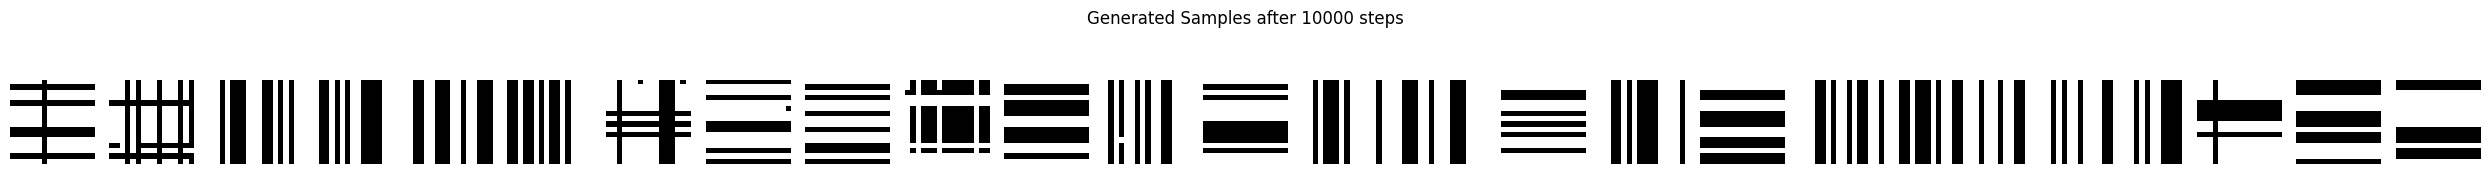

In [24]:
# Solution :
fig, axes = plt.subplots(1, num_gen_samples, figsize=(num_gen_samples, 2))
for i in range(num_gen_samples):
    ax = axes[i]
    ax.imshow(S_generated[i].reshape(16, 16), cmap='gray', vmin=0, vmax=1)
    ax.axis('off')

plt.suptitle(f"Generated Samples after {steps_for_mixing} steps")
plt.tight_layout()

Solution:

We obtain clean images (low noise) of images with horizontal and vertical bars. While the dataset contains only images with horizontal or vertical bars exclusively, the BM generates mixture images containing both horizontal and vertical bars. Since the Boltzmann Machine relies on additive pairwise interactions, it can assign low energy to the superposition of both patterns because that state simultaneously satisfies both the horizontal and vertical neighbor constraints learned from the data.

**3.9** Plot the trajectory of a single chain. Initialize it randomly, and plot what it looks like after $1, 100, 500, 10^3, 10^4, 10^5$ steps. Does the pattern significantly change between step $10^4$ and step $10^5$ ?

In [25]:
# Your code here

Your answer here:

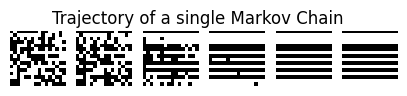

In [26]:
# Solution:
s_single = np.zeros((1, 16**2))
s_single=rng.binomial(1, 0.5, size=(1, d))
steps_to_save=[1,99,400, 500, 9000, 90_000]
history = []
for steps in steps_to_save:
    s_single = gibbs_steps(h, J, s_single, num_steps=steps)
    history.append(s_single[0].copy())

# Plot the trajectory of this single walker
fig, axes = plt.subplots(1, len(steps_to_save), figsize=(5, 1))
for i in range(len(steps_to_save)):
    axes[i].imshow(history[i].reshape(16, 16), cmap='gray', vmin=0, vmax=1)
    axes[i].axis('off')
plt.suptitle("Trajectory of a single Markov Chain")
plt.show()

Answer:

No, the sample does not change significantly between steps $10^4$ and $10^5$. Not needed: this hints at the fact that the chain does not mix well.

# 4. Restricted Boltzmann machines

The Boltzmann machine can struggle to capture some structure in the data. Moreover, it can be costly to train all the pairwise interaction. To mitigate these problems, the restricted Boltzmann machine (RBM) was introduced. An RBM adds a layer of hidden units $s_j^h, j=1, ..., d_H$, and only connects the hidden and visible units $s_i^V, i=1, ..., d$.

The Restricted Boltzmann machine (RBM) assumes the following energy function:
$$
E_{\mathbf h, \tilde{\mathbf{h}} , W}(\mathbf s^v, \mathbf s^h)=-\sum_{i=1}^{d} h_i s^V_i-\sum_{j=1}^{d_H}\tilde h_j s_j^H-\sum_{i=1}^d \sum_{j=1}^{d_H} W_{ij} s_i^V s^H_j.
$$
$\mathbf s^V \in \{0,1\}^d$ are the visible units (the image), $\mathbf s^H\in\{0,1\}^{d_H}$ are the hidden units, $W\in \mathbb{R}^{d\times d_H}$ is the weight matrix connecting visible and hidden units, and $\mathbf h\in \mathbb{R}^{d}$ and $\tilde{\mathbf{h}}\in \mathbb{R}^{d_H}$ are the visible and hidden biases (or external fields) vectors.

Because there are no intra-layer connections, the conditional probabilities factorize nicely. This allows to perform __Block Gibbs Sampling__, updating all hidden units at once, then all visible units at once:
$$
P_{\mathbf h, \tilde{\mathbf{h}}, W}(s_j^H=1| \mathbf s^V)=\sigma\left(\tilde h_j+\sum_{i=1}^{d}W_{ij}s_i^V\right),
$$
$$
P_{\mathbf h, \tilde{\mathbf{h}}, W}(s_i^V=1| \mathbf s^H)=\sigma\left(h_i+\sum_{j=1}^{d_H}W_{ij}s_j^H\right).
$$

**4.1** Implement a function performing one step of the Block Gibbs Sampling. It should take the current visible state $\mathbf s^V$, and parameters $W$, $\mathbf h$ and $\tilde{\mathbf{h}}$ as inputs. Then
1. Compute the probabilities for hidden units given $\mathbf s^V$.
2. Sample the hidden state $\mathbf s^H$ from these probabilities.
3. Compute the probabilities for the visible units given this new $\mathbf s^H$.
4. Sample a new visible state $\mathbf s^V$.
The function should return both the new visible (sampled in 4) and hidden state (sampled in 2).

Note: we could continue the chain by again sampling the hidden variables with the new visible variables, etc. Doing this $k$ times is refered to CD-k (contrastive divergence with k steps). For now we keep $k=1$, but larger $k$ will be used in the next exercise.

In [27]:
# Your code here:

In [28]:
# Solution:

def rbm_block_gibbs_step(s_v, W, h, h_tilde):
    # Sample h given v
    hidden_activation = np.dot(s_v, W) + h_tilde
    hidden_prob = sigmoid(hidden_activation)
    hidden_sample = np.random.binomial(1, hidden_prob)
    
    # 2. Sample v given h
    visible_activation = np.dot(hidden_sample, W.T) + h
    visible_prob = sigmoid(visible_activation)
    visible_sample = np.random.binomial(1, visible_prob)
    
    return visible_sample, hidden_sample

**4.2** The gradient descent to obtain $\hat W, \hat{\mathbf{h}}, \hat{\tilde{\mathbf{h}}}$ that maximize the likelihood in this setting is given by
$$
W_{ij}(t+1)=W_{ij}(t)-\eta(<s_i^V s_j^H>_{model}-<s_i^V s_j^H>_{emp}),
$$
$$
h_{i}(t+1)=h_{i}(t)-\eta(<s_i^V>_{model}-<s_i^V>_{emp}),
$$
$$
\tilde h_{j}(t+1)=\tilde h_{j}(t)-\eta(<s_j^H>_{model}-<s_j^H>_{emp}).
$$
Initialize $W$ with small random noise, and set the biases $\mathbf h$ and $\tilde{\mathbf{h}}$ to zeros. Set $d_H=100$. Then, run GD for $1000$ steps with $\eta=0.5$:
1. Set $\mathbf s^V$ to be a sample of the dataset.
2. Compute the probability $P_{\mathbf h, \tilde{\mathbf{h}}, W}(\mathbf s^H_j=1| \mathbf s^V)$ for each hidden unit, and sample $\mathbf s^H$ from these probabilities. $S^H$ designates the concatenation of $\mathbf s^H$ for every sample of the dataset, and is an array of size $n\times d_H$.
3. Do this for every sample of the dataset in a vectorized form, and compute $<W_{ij}>_{emp}\approx \frac{1}{n}S^T S^H$ as well as $<s_i^V>_{emp}$ and $<s_j^H>_{emp}$.
4. Compute the probability $P_{\mathbf h, \tilde{\mathbf{h}}, W}(\mathbf s^V_i=1| \mathbf s^H)$ for each visible unit, where $\mathbf s^H$ is computed in step 2. Sample $\mathbf s^V_{new}$ from this probability.
5. Compute the probability $P_{\mathbf h, \tilde{\mathbf{h}}, W}(\mathbf s^H_i=1| \mathbf s^V_{new})$ for each hidden unit, where $\mathbf s^V_{new}$ is computed in step 4. Sample $\mathbf s^H_{new}$ from this probability.
6. Do this for every sample of the dataset in a vectorized form, and estimate $<W_{ij}>_{model}\approx \frac{1}{n}S_{new}^T S^H_{new}$ as well as $<s_i^V>_{model}$ and $<s_j^H>_{model}$. $S_{new}$ designates the concatenation of $\mathbf s^V_{new}$ for every sample of the dataset and is of size $n\times d_H$, and similarly for $S^H_{new}$ which is of size $n\times d$.
7. Perform the gradient step.
To monitor the convergence, again print the reconstruction error
$$
E_{recon}=\|S - S_{new}(t)\|^2
$$
every 50 gradient descent step. $S$ is the data, while $S_{new}(t)$ are the generated samples used to compute $<\cdot>_{model}$ at iteration $t$ of the gradient descent. $\| \cdot \|$ is the Frobenius norm. 

Note: We do only one step of block Gibbs sampling. This is mainly for computational reasons, and has been shown to already yield good results. However, to estimate the $<\cdot>_{model}$ averages accurately, this chain should be run until equilibration.

Hint: you can use your previous implementation of the block Gibbs sampler to sample $S^H$ and $S_{new}$.


In [29]:
# Your code here:

In [30]:
# Solution:

n_hidden = 100 # 2*size should be enough theoretically, but GD does not seem to work that well in that case.
eta = 0.5
num_iter_GD = 1000

# Initialize parameters
W = np.random.normal(0, 0.01, (d, n_hidden))
h = np.zeros(d)        # Visible bias
h_tilde = np.zeros(n_hidden) # Hidden bias

print("Starting RBM Training (CD-1)...")

for epoch in range(num_iter_GD):
    
    visible = data_BAS
    
    # The function performs: visible -> hidden -> visible_new
    visible_new, hidden = rbm_block_gibbs_step(visible, W, h, h_tilde)
    
    # <s_i^V s_j^H>_emp
    W_emp = np.dot(visible.T, hidden) / n

    # The helper function stopped at visible_new, we compute hidden_new manually. Alternatively, one can also call rbm_block_gibbs_step again.
    hidden_new_prob = sigmoid(np.dot(visible_new, W) + h_tilde)
    hidden_new = np.random.binomial(1, hidden_new_prob)
    
    #  <s_i^V s_j^H>_model
    W_model = np.dot(visible_new.T, hidden_new) / n

    # Gradient step:
    W = W - eta * (W_model - W_emp)
    h = h - eta * np.mean(visible_new - visible, axis=0)
    h_tilde = h_tilde - eta * np.mean(hidden_new - hidden, axis=0)

    if epoch % 50 == 0:
        error = np.mean((visible - visible_new)**2)
        print(f"Epoch {epoch}: Reconstruction Error = {error:.4f}")

Starting RBM Training (CD-1)...
Epoch 0: Reconstruction Error = 0.5012
Epoch 50: Reconstruction Error = 0.3124
Epoch 100: Reconstruction Error = 0.1282
Epoch 150: Reconstruction Error = 0.0785
Epoch 200: Reconstruction Error = 0.0581
Epoch 250: Reconstruction Error = 0.0470
Epoch 300: Reconstruction Error = 0.0383
Epoch 350: Reconstruction Error = 0.0340
Epoch 400: Reconstruction Error = 0.0301
Epoch 450: Reconstruction Error = 0.0270
Epoch 500: Reconstruction Error = 0.0244
Epoch 550: Reconstruction Error = 0.0210
Epoch 600: Reconstruction Error = 0.0199
Epoch 650: Reconstruction Error = 0.0189
Epoch 700: Reconstruction Error = 0.0182
Epoch 750: Reconstruction Error = 0.0163
Epoch 800: Reconstruction Error = 0.0161
Epoch 850: Reconstruction Error = 0.0145
Epoch 900: Reconstruction Error = 0.0136
Epoch 950: Reconstruction Error = 0.0122


**4.3** Generate new samples by running the Block Gibbs sampler for $10^4$ steps using the learnt parameters. Generate $25$ new samples and plot them. What do you observe ? Do you generate images with both vertical and horizontal lines ?

In [31]:
# Your code here:

Your answer here:

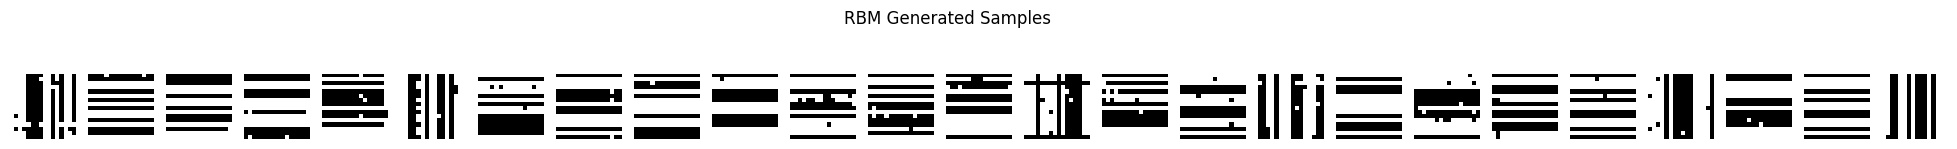

In [32]:
# Solution:

num_samples=25
# Generate Samples
S_noise = np.random.binomial(1, 0.5, size=(num_samples, d))
S_curr = S_noise.copy()

# Run for 10_000 steps to mix
for _ in range(10000):
    S_curr, _ = rbm_block_gibbs_step(S_curr, W, h, h_tilde)

# Plot Generated Samples
fig, axes = plt.subplots(1, num_samples, figsize=(num_samples, 2))
for i in range(num_samples):
    axes[i].imshow(S_curr[i].reshape(16, 16), cmap='gray', vmin=0, vmax=1)
    axes[i].axis('off')
plt.suptitle("RBM Generated Samples")
plt.show()

Solution:

The produced images are a slightly noisy, but they do (almost) not present both vertical and horizontal lines.

**4.4** Reproduce point 4.2 and 4.3 with only 10 hidden units. What do you observe ? Give a brief possible explanation.

Starting RBM Training (CD-1)...
Epoch 0: Reconstruction Error = 0.4992
Epoch 50: Reconstruction Error = 0.4288
Epoch 100: Reconstruction Error = 0.3927
Epoch 150: Reconstruction Error = 0.3778
Epoch 200: Reconstruction Error = 0.3714
Epoch 250: Reconstruction Error = 0.3667
Epoch 300: Reconstruction Error = 0.3663
Epoch 350: Reconstruction Error = 0.3614
Epoch 400: Reconstruction Error = 0.3629
Epoch 450: Reconstruction Error = 0.3616
Epoch 500: Reconstruction Error = 0.3603
Epoch 550: Reconstruction Error = 0.3599
Epoch 600: Reconstruction Error = 0.3597
Epoch 650: Reconstruction Error = 0.3586
Epoch 700: Reconstruction Error = 0.3577
Epoch 750: Reconstruction Error = 0.3565
Epoch 800: Reconstruction Error = 0.3565
Epoch 850: Reconstruction Error = 0.3544
Epoch 900: Reconstruction Error = 0.3590
Epoch 950: Reconstruction Error = 0.3582


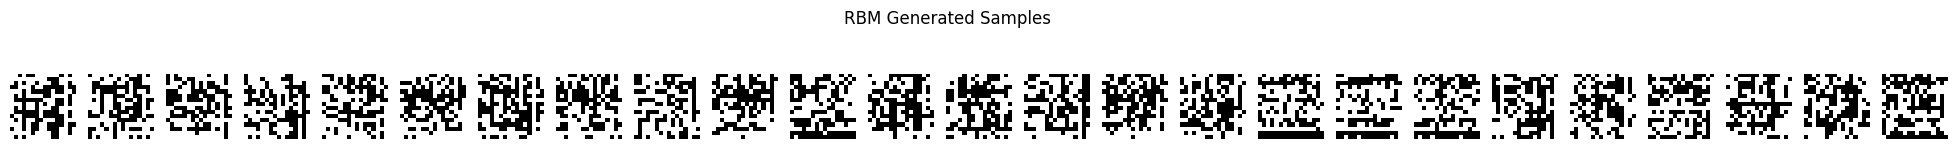

In [33]:
# Solution:

n_hidden = 10 # 2*size should be enough theoretically enough, but GD does not seem to work that well in that case.
eta = 0.5
num_iter_GD = 1000

# Initialize parameters
W = np.random.normal(0, 0.01, (d, n_hidden))
h = np.zeros(d)        # Visible bias
h_tilde = np.zeros(n_hidden) # Hidden bias

print("Starting RBM Training (CD-1)...")

for epoch in range(num_iter_GD):
    
    visible = data_BAS
    
    # The function performs: visible -> hidden -> visible_new
    visible_new, hidden = rbm_block_gibbs_step(visible, W, h, h_tilde)
    
    # <s_i^V s_j^H>_emp
    W_emp = np.dot(visible.T, hidden) / n

    # The helper function stopped at visible_new, we compute hidden_new manually. Alternatively, one can also call rbm_block_gibbs_step again.
    hidden_new_prob = sigmoid(np.dot(visible_new, W) + h_tilde)
    hidden_new = np.random.binomial(1, hidden_new_prob)
    
    #  <s_i^V s_j^H>_model
    W_model = np.dot(visible_new.T, hidden_new) / n

    # Gradient step:
    W = W - eta * (W_model - W_emp)
    h = h - eta * np.mean(visible_new - visible, axis=0)
    h_tilde = h_tilde - eta * np.mean(hidden_new - hidden, axis=0)

    if epoch % 50 == 0:
        error = np.mean((visible - visible_new)**2)
        print(f"Epoch {epoch}: Reconstruction Error = {error:.4f}")

# Solution:

num_samples=25
# Generate Samples
S_noise = np.random.binomial(1, 0.5, size=(num_samples, d))
S_curr = S_noise.copy()

# Run for 10_000 steps to mix
for _ in range(10_000):
    S_curr, _ = rbm_block_gibbs_step(S_curr, W, h, h_tilde)

# Plot Generated Samples
fig, axes = plt.subplots(1, num_samples, figsize=(num_samples, 2))
for i in range(num_samples):
    axes[i].imshow(S_curr[i].reshape(16, 16), cmap='gray', vmin=0, vmax=1)
    axes[i].axis('off')
plt.suptitle("RBM Generated Samples")
plt.show()

Solution:

The images are very noisy: one does barely recognize the lines. 10 hidden units are not sufficient/expressive enough for this dataset. Not needed: this is expected, as one already has for instance 16 possible independent horizontal lines that seem to appear with equal probability.

# 5. Restricted Boltzmann machines on real data

**5.1** Load the dataset *mnist.npy* using the numpy `load` function. It contains black and white $28\times 28$ images of hand-drawn digits 6 and 9. These images are taken from the MNIST dataset. Load the labels *mnist_labels.npy*, containing the labels (6 or 9) of each sample. Plot the first 5 images of the dataset, with as title the label of each image.

In [34]:
# Your code here

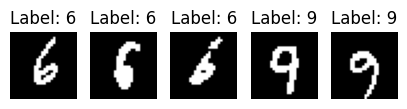

In [35]:
mnist = np.load('mnist.npy')
labels = np.load('mnist_labels.npy')
num_images=5
fig, axes = plt.subplots(1, num_images, figsize=(num_images, 2))
for i in range(num_images):
    axes[i].imshow(mnist[i], cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f"Label: {labels[i]}")
plt.show()

**5.2** Flatten the data. Using numpy's built-in functions, compute the first 2 principal components of the dataset (i.e. the two right singular vectors with largest singular values). Make sure they are normalized with respect to the euclidian norm.

Note: for this exercise, do not normalize or center the data. You can do the full singular value decomposition (even though we only need the 2 leading singular vectors). You can use numpy functions to compute this decomposition.

In [36]:
# Your code here

In [37]:
# Solution:
flatten_MNIST=mnist.reshape(mnist.shape[0], -1)
_, _, Vt = np.linalg.svd(flatten_MNIST)
print('Norm 1st principal component : ', np.linalg.norm(Vt[0]))
print('Norm 2nd principal component : ', np.linalg.norm(Vt[1]))

Norm 1st principal component :  1.0
Norm 2nd principal component :  1.0000000000000002


**5.3** Project each datapoint on the first 2 principal components (as an example, see figure 2 from lecture 2). Plot the resulting points, coloring them in different colors for each class, i.e. one color for the 6s and another color for the 9s. What do you notice ?

In [38]:
# Your code here

Your answer here:

Text(0, 0.5, '2nd Principal Component')

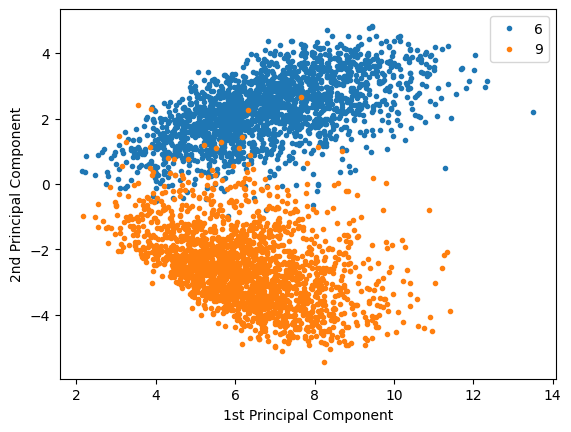

In [39]:
# Solution
plt.plot(flatten_MNIST[labels==6]@Vt[0].reshape((-1,1)), flatten_MNIST[labels==6]@Vt[1].reshape((-1,1)), marker='.', linestyle='', label='6')
plt.plot(flatten_MNIST[labels==9]@Vt[0].reshape((-1,1)), flatten_MNIST[labels==9]@Vt[1].reshape((-1,1)), marker='.', linestyle='', label='9')
plt.legend()
plt.xlabel('1st Principal Component')
plt.ylabel('2nd Principal Component')

Solution:

The 6s and 9s form two different, separated clusters.

**5.4** In the previous exercise, we used contrastive divergence with one step (CD-1), i.e. 1 step of Gibbs sampling. Implement the training using k-CD. This means that instead of computing $S^V_{new}$ and $S^H_{new}$ in only one step, you should repeat this procedure $k$ times.

Train the model on the MNIST data for $k=5$, $\eta=0.5$ and $200$ gradient descent steps. Initialize the visible and hidden biases/fields at $0$, and the coupling between the visible and hidden units to a small noise. Use $200$ hidden units. You can reuse or copy-paste previous code if needed.

Note: executing this part of the code can take ~15-20 minutes.

In [85]:
# Solution:
k=5

n = flatten_MNIST.shape[0]
d = flatten_MNIST.shape[1]

n_hidden = 200
eta = 0.5
num_iter_GD = 200

# Initialize parameters
W = np.random.normal(0, 0.01, (d, n_hidden))
h = np.zeros(d)        # Visible bias
h_tilde = np.zeros(n_hidden) # Hidden bias

print(f"Starting RBM Training (CD-{k})...")

for epoch in range(num_iter_GD):
    
    visible = flatten_MNIST
    
    # The function performs: visible -> hidden -> visible_new
    visible_new, hidden = rbm_block_gibbs_step(visible, W, h, h_tilde)
    
    # <s_i^V s_j^H>_emp
    W_emp = np.dot(visible.T, hidden) / n

    hidden_new = hidden
    for _ in range(k-1): # We only need to do this k-1 times, we already generatated a new sample of the visible units above, and we generate the last hidden unit below.
        visible_new, hidden = rbm_block_gibbs_step(visible_new, W, h, h_tilde)
    
    # The helper function stopped at visible_new, we compute hidden_new manually. Alternatively, one can also call rbm_block_gibbs_step again.
    hidden_new_prob = sigmoid(np.dot(visible_new, W) + h_tilde)
    hidden_new = np.random.binomial(1, hidden_new_prob)
    
    #  <s_i^V s_j^H>_model
    W_model = np.dot(visible_new.T, hidden_new) / n

    # Gradient step:
    W = W - eta * (W_model - W_emp )
    h = h - eta * np.mean(visible_new - visible, axis=0)
    h_tilde = h_tilde - eta * np.mean(hidden_new - hidden, axis=0)

    if epoch % 1 == 0:
        error = np.mean((visible - visible_new)**2)
        print(f"Epoch {epoch}: Reconstruction Error = {error:.4f}")

Starting RBM Training (CD-5)...
Epoch 0: Reconstruction Error = 0.5005
Epoch 1: Reconstruction Error = 0.2629
Epoch 2: Reconstruction Error = 0.4427
Epoch 3: Reconstruction Error = 0.4083
Epoch 4: Reconstruction Error = 0.3389
Epoch 5: Reconstruction Error = 0.2530
Epoch 6: Reconstruction Error = 0.2413
Epoch 7: Reconstruction Error = 0.1676
Epoch 8: Reconstruction Error = 0.3390
Epoch 9: Reconstruction Error = 0.1996
Epoch 10: Reconstruction Error = 0.1672
Epoch 11: Reconstruction Error = 0.3161
Epoch 12: Reconstruction Error = 0.1852
Epoch 13: Reconstruction Error = 0.1926
Epoch 14: Reconstruction Error = 0.1495
Epoch 15: Reconstruction Error = 0.2966
Epoch 16: Reconstruction Error = 0.2000
Epoch 17: Reconstruction Error = 0.1813
Epoch 18: Reconstruction Error = 0.1615
Epoch 19: Reconstruction Error = 0.2781
Epoch 20: Reconstruction Error = 0.1658
Epoch 21: Reconstruction Error = 0.2151
Epoch 22: Reconstruction Error = 0.1631
Epoch 23: Reconstruction Error = 0.2373
Epoch 24: Reconstr

__5.5__ Write a function computing the energy $E$, given the values of visible and hidden units, and parameters $W$, $\mathbf{h}$ and $\tilde{\mathbf{h}}$.

In [86]:
# Your code here:

In [87]:
# Solution

def compute_energy(visible, hidden, W, h, h_tilde):
    bias_h = np.dot(visible, h)
    bias_h_tilde = np.dot(hidden, h_tilde)
    interaction = np.sum(np.dot(visible, W) * hidden, axis=1)
    
    return -bias_h - bias_h_tilde - interaction

__5.6__ We now generate a new sample. Initialize it uniformly at random with $0$ and $1$ with $50\%$ probability, and plot how it looks like after $k=1, 10, 100, 500, 1000$ steps of CD. Additionally, compute the energy at each step and save it in a list or array.

In [88]:
# Your code here:

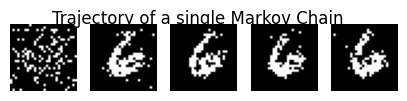

In [89]:
# Solution:
new_sample=rng.binomial(1, 0.5, size=(1, d))
steps_to_save=[1, 9, 80 ,400, 500]
history = []
energies=[]
for steps in steps_to_save:
    for _ in range(steps):
        new_sample, hidden_units = rbm_block_gibbs_step(new_sample, W, h, h_tilde)
        energies.append(compute_energy(new_sample, hidden_units, W, h, h_tilde))
    history.append(new_sample[0].copy())

# Plot the trajectory of this single walker
fig, axes = plt.subplots(1, len(steps_to_save), figsize=(5, 1))
for i in range(len(steps_to_save)):
    axes[i].imshow(history[i].reshape(28, 28), cmap='gray')#, vmin=0, vmax=1) <-- if one plots probabilities
    axes[i].axis('off')
plt.suptitle("Trajectory of a single Markov Chain")
plt.show()

__5.7__ Plot the energy computed previously as a function of the number of steps.

Text(0, 0.5, 'Energy')

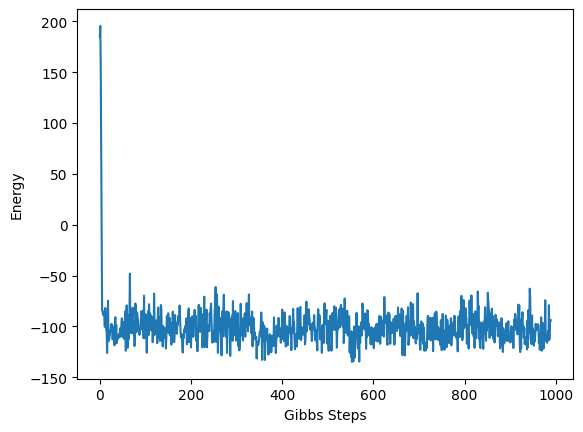

In [90]:
plt.plot(energies)
plt.xlabel('Gibbs Steps')
plt.ylabel('Energy')

__5.8__ Generate new samples by running the Block Gibbs sampler for $1000$ steps using the learnt parameters. Generate $500$ new samples and plot them the first $25$ obtained samples.

In [91]:
# Your code here

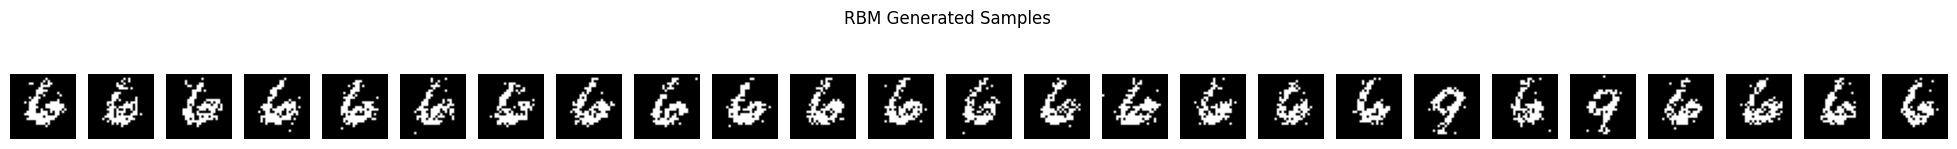

In [92]:
# Solution:

num_samples=250
# Generate Samples
new_samples = np.random.binomial(1, 0.5, size=(num_samples, d))

# Run for 1000 steps to mix
for _ in range(1000):
    new_samples, _ = rbm_block_gibbs_step(new_samples, W, h, h_tilde)

# Plot Generated Samples
fig, axes = plt.subplots(1, 25, figsize=(25, 2))
for i in range(25):
    axes[i].imshow(new_samples[i].reshape(28, 28), cmap='gray', vmin=0, vmax=1)
    axes[i].axis('off')
plt.suptitle("RBM Generated Samples")
plt.show()

__5.9__ Project the obtained samples on the 2 principal components obtained before and plot them. Also plot the projection of the trained samples as before. 

Text(0, 0.5, '2nd Principal Component')

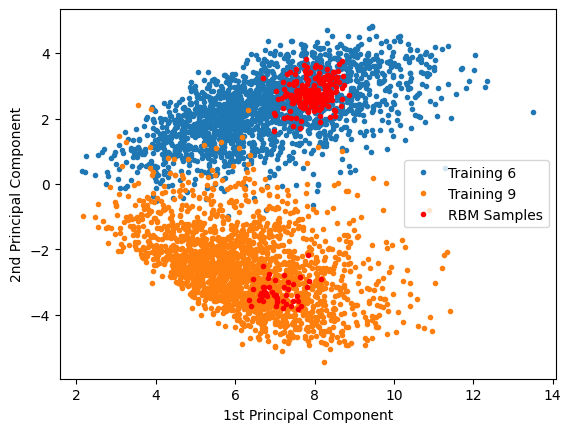

In [93]:
# Solution
plt.plot(flatten_MNIST[labels==6]@Vt[0].reshape((-1,1)), flatten_MNIST[labels==6]@Vt[1].reshape((-1,1)), marker='.', linestyle='', label='Training 6')
plt.plot(flatten_MNIST[labels==9]@Vt[0].reshape((-1,1)), flatten_MNIST[labels==9]@Vt[1].reshape((-1,1)), marker='.', linestyle='', label='Training 9')
plt.plot(new_samples@Vt[0].reshape((-1,1)), new_samples@Vt[1].reshape((-1,1)), marker='.', linestyle='', color='r', label='RBM Samples')
plt.legend()
plt.xlabel('1st Principal Component')
plt.ylabel('2nd Principal Component')